In [1]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 

In [2]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [3]:
# IMPORTING DATASET 
dataset = pd.read_csv('input//apple_share_price.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])

In [4]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

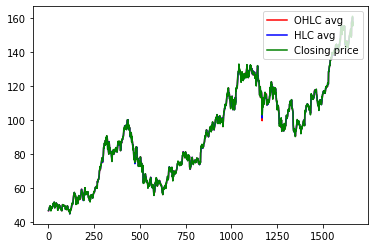

In [5]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [6]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [7]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [8]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = preprocessing.new_dataset(train_OHLC, 1)
testX, testY = preprocessing.new_dataset(test_OHLC, 1)

In [9]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [10]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [11]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=150, batch_size=1, verbose=2)

Epoch 1/150


2022-05-17 18:02:55.106055: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1246/1246 - 2s - loss: 0.1092 - 2s/epoch - 2ms/step
Epoch 2/150
1246/1246 - 1s - loss: 0.0788 - 670ms/epoch - 538us/step
Epoch 3/150
1246/1246 - 1s - loss: 0.0642 - 665ms/epoch - 534us/step
Epoch 4/150
1246/1246 - 1s - loss: 0.0554 - 732ms/epoch - 587us/step
Epoch 5/150
1246/1246 - 1s - loss: 0.0498 - 706ms/epoch - 567us/step
Epoch 6/150
1246/1246 - 1s - loss: 0.0461 - 695ms/epoch - 558us/step
Epoch 7/150
1246/1246 - 1s - loss: 0.0436 - 692ms/epoch - 555us/step
Epoch 8/150
1246/1246 - 1s - loss: 0.0420 - 683ms/epoch - 548us/step
Epoch 9/150
1246/1246 - 1s - loss: 0.0408 - 732ms/epoch - 588us/step
Epoch 10/150
1246/1246 - 1s - loss: 0.0399 - 682ms/epoch - 547us/step
Epoch 11/150
1246/1246 - 1s - loss: 0.0391 - 668ms/epoch - 536us/step
Epoch 12/150
1246/1246 - 1s - loss: 0.0385 - 660ms/epoch - 530us/step
Epoch 13/150
1246/1246 - 1s - loss: 0.0380 - 740ms/epoch - 594us/step
Epoch 14/150
1246/1246 - 1s - loss: 0.0376 - 717ms/epoch - 576us/step
Epoch 15/150
1246/1246 - 1s - loss: 0.0371 - 6

In [12]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [13]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [14]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 3.14
Test RMSE: 4.74


In [15]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [16]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

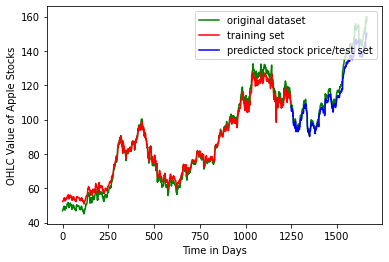

In [17]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [18]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

Last Day Value: 150.2447967529297
Next Day Value: 137.28697204589844


/var/folders/n6/_xz71h9d59l3nqv8qtwzz1lm0000gn/T/ipykernel_5230/51515364.py:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Last Day Value:", np.asscalar(last_val))
/var/folders/n6/_xz71h9d59l3nqv8qtwzz1lm0000gn/T/ipykernel_5230/51515364.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Next Day Value:", np.asscalar(last_val*next_val))
